In [3]:
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow import keras

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Chargement des données

In [7]:
import os

with open("/content/drive/My Drive/Datasets/Data_semEval2022/En_data/en.train.json", "r") as file_handler:
  dataset = json.load(file_handler)


In [8]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/En_data/en.dev.json", "r") as file_handler:
    dataset_dev = json.load(file_handler)

In [9]:
char_target = [i['char'] for i in dataset]
glosses = [i['gloss'] for i in dataset]

In [10]:
char_dev = [i['char'] for i in dataset_dev]
glosses_dev = [i['gloss'] for i in dataset_dev]

In [11]:
print(len(glosses_dev))

6375


In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Préparation des données

### Preparing data for char embedding

In [13]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

# creates mapping of unique characters to integers
chars_train = []
#print(chars)

idx = 0
char_to_int = dict()
int_to_char = dict()

for gloss in glosses:
  chars_gloss = []
  for word in word_tokenize(gloss) :
    chars = list(word)
    chars_gloss.extend(chars)
    for char in chars : 
      if char not in char_to_int : 
        char_to_int[char] = idx
        int_to_char[idx] = char
        idx+=1
  chars_train.append(chars_gloss)



print("The number of total characters are", len(list(char_to_int.keys())))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
The number of total characters are 139


In [14]:
print(list(char_to_int.keys()))

['A', 'b', 'l', 'e', 'm', 'i', 's', 'h', '.', 'v', 'o', 'c', 'a', 'g', 'n', 'r', 'H', 'd', 'u', 't', ',', 'p', 'y', 'f', 'w', 'T', ';', 'M', 'j', 'k', 'P', 'I', 'D', 'q', 'O', 'R', "'", 'x', 'S', 'B', '(', ')', ':', 'L', 'W', 'z', 'J', 'C', 'G', 'E', '1', '6', '5', '–', '7', '2', '8', 'U', '-', 'N', 'F', '/', 'é', 'à', 'V', '9', '0', '3', '`', 'K', 'Y', 'Z', '°', 'ƒ', 'X', '→', '⊆', '−', '=', '{', '∈', '}', '—', '%', '4', '!', 'ñ', '₨', 'á', 'É', '£', 'Q', '♭', 'ˌ', '*', '[', ']', '½', 'ü', '¨', 'ó', 'ê', 'Θ', '?', 'ū', 'ç', '+', '′', 'ḫ', 'τ', 'ä', '·', 'í', '≈', '&', 'ș', '¯', '@', 'α', 'β', 'ô', '<', 'ā', 'ℓ', '\\', '_', '^', '×', '⊇', 'Α', '#', '₄', 'ə', '|', '†', '‾', '>', 'ö', '~']


In [15]:
print(chars_train[1])

['A', 'v', 'o', 'c', 'a', 'l', 'g', 'e', 'n', 'r', 'e', 'i', 'n', 'H', 'i', 'n', 'd', 'u', 's', 't', 'a', 'n', 'i', 'c', 'l', 'a', 's', 's', 'i', 'c', 'a', 'l', 'm', 'u', 's', 'i', 'c']


In [16]:
#max_tokens = len(list(lemm2Idx))
#print(max_tokens)
#max_tokens_ = len(list(lemm2Idx))

#max_tokens_dev = len(lemm2Idx_dev)

vectorize_layer = TextVectorization(
    # Max vocab size. Any words outside of the max_tokens most common ones
    # will be treated the same way: as "out of vocabulary" (OOV) tokens.
    max_tokens=214,
    # Output integer indices, one per string token
    output_mode="int",
    # Always pad or truncate to exactly this many tokens
    output_sequence_length=300
)

In [17]:
vectorize_layer.set_vocabulary(list(char_to_int.keys()))

In [18]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'A',
 'b',
 'l',
 'e',
 'm',
 'i',
 's',
 'h',
 '.',
 'v',
 'o',
 'c',
 'a',
 'g',
 'n',
 'r',
 'H',
 'd',
 'u',
 't',
 ',',
 'p',
 'y',
 'f',
 'w',
 'T',
 ';',
 'M',
 'j',
 'k',
 'P',
 'I',
 'D',
 'q',
 'O',
 'R',
 "'",
 'x',
 'S',
 'B',
 '(',
 ')',
 ':',
 'L',
 'W',
 'z',
 'J',
 'C',
 'G',
 'E',
 '1',
 '6',
 '5',
 '–',
 '7',
 '2',
 '8',
 'U',
 '-',
 'N',
 'F',
 '/',
 'é',
 'à',
 'V',
 '9',
 '0',
 '3',
 '`',
 'K',
 'Y',
 'Z',
 '°',
 'ƒ',
 'X',
 '→',
 '⊆',
 '−',
 '=',
 '{',
 '∈',
 '}',
 '—',
 '%',
 '4',
 '!',
 'ñ',
 '₨',
 'á',
 'É',
 '£',
 'Q',
 '♭',
 'ˌ',
 '*',
 '[',
 ']',
 '½',
 'ü',
 '¨',
 'ó',
 'ê',
 'Θ',
 '?',
 'ū',
 'ç',
 '+',
 '′',
 'ḫ',
 'τ',
 'ä',
 '·',
 'í',
 '≈',
 '&',
 'ș',
 '¯',
 '@',
 'α',
 'β',
 'ô',
 '<',
 'ā',
 'ℓ',
 '\\',
 '_',
 '^',
 '×',
 '⊇',
 'Α',
 '#',
 '₄',
 'ə',
 '|',
 '†',
 '‾',
 '>',
 'ö',
 '~']

### Construction du modèle

In [19]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [20]:
import tensorflow as tf
import tensorflow_addons as tfa
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
# lr and wd can be a function or a tensor

lr = 1e-1 * schedule(step)

learning_rate=1e-3

wd = lambda: 1e-4 * schedule(step)

weight_decay=1e-6,

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [53]:
import torch.optim as optim

opt = keras.optimizers.Adam(learning_rate=0.01)

In [86]:
model = Sequential()
model.add(Input(shape=(1,), dtype="string"))

In [87]:
model.add(vectorize_layer)

In [88]:
from tensorflow.keras import layers
# Note that we're using max_tokens + 1 here, since there's an
# out-of-vocabulary (OOV) token that gets added to the vocab.

len_gloses = 43608

model.add(Embedding(170+1, 128))

#model.add(Dense(128))


#model.add(Bidirectional(LSTM(units=192, return_sequences=True), merge_mode = 'ave'))

#model.add(Dense(192))


model.add(Dense(64))


model.add(tf.keras.layers.ConvLSTM1D(256, return_sequences=False, activation = "softmax"))


TypeError: ignored

In [ ]:
 model.compile(
    optimizer=opt,
    loss='mse',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 300, 128)          21888     
                                                                 
 dense_6 (Dense)             (None, 300, 128)          16512     
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 192)         493056    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 300, 192)          37056     
                                                                 
 lstm_5 (LSTM)               (None, 256)              

In [ ]:
print(chars_train[0])
print(len(char_target))

['(', 'P', 'a', 'r', 'm', 'é', 't', 'o', 'n', 'y', 'm', 'i', 'e', ')', 'P', 'l', 'a', 'c', 'e', 'd', 'e', 'p', 'r', 'o', 'f', 'e', 's', 's', 'e', 'u', 'r', 'd', 'a', 'n', 's', 'u', 'n', 'e', 'u', 'n', 'i', 'v', 'e', 'r', 's', 'i', 't', 'é', ',', 'e', 't', 'p', 'a', 'r', 'e', 'x', 't', 'e', 'n', 's', 'i', 'o', 'n', 'd', 'a', 'n', 's', 'u', 'n', 'e', 'g', 'r', 'a', 'n', 'd', 'e', 'é', 'c', 'o', 'l', 'e', 'o', 'u', 'u', 'n', 'é', 't', 'a', 'b', 'l', 'i', 's', 's', 'e', 'm', 'e', 'n', 't', 'd', "'", 'e', 'n', 's', 'e', 'i', 'g', 'n', 'e', 'm', 'e', 'n', 't', 's', 'u', 'p', 'é', 'r', 'i', 'e', 'u', 'r', '.']
43608


### Entraînement du modèle

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(glosses, char_target,
                    epochs=10,
                    batch_size=192,
                    validation_data = (glosses_dev, char_dev))

Epoch 1/10
228/228 [==============================] - 338s 1s/step - loss: 0.1560 - accuracy: 0.9126 - val_loss: 0.1287 - val_accuracy: 0.9956
Epoch 2/10
228/228 [==============================] - 283s 1s/step - loss: 0.1329 - accuracy: 0.9959 - val_loss: 0.1289 - val_accuracy: 0.9956
Epoch 3/10
228/228 [==============================] - 269s 1s/step - loss: 0.1329 - accuracy: 0.9959 - val_loss: 0.1286 - val_accuracy: 0.9956
Epoch 4/10
228/228 [==============================] - 265s 1s/step - loss: 0.1329 - accuracy: 0.9959 - val_loss: 0.1288 - val_accuracy: 0.9956
Epoch 5/10
228/228 [==============================] - 269s 1s/step - loss: 0.1329 - accuracy: 0.9959 - val_loss: 0.1287 - val_accuracy: 0.9956
Epoch 6/10
228/228 [==============================] - 267s 1s/step - loss: 0.1329 - accuracy: 0.9959 - val_loss: 0.1285 - val_accuracy: 0.9956
Epoch 7/10
228/228 [==============================] - 267s 1s/step - loss: 0.1329 - accuracy: 0.9959 - val_loss: 0.1288 - val_accuracy: 0.9956

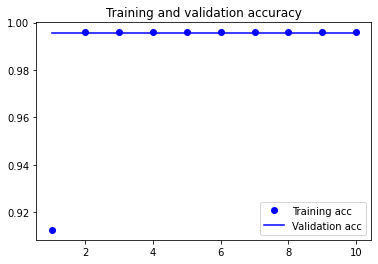

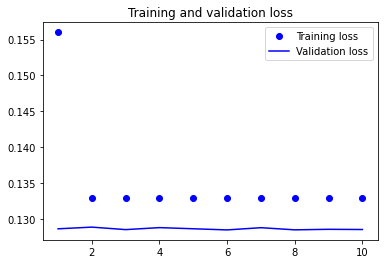

In [ ]:
#Visualisation des résultats de l'entraînement.
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#sauvegarde du modèle
model.save('_fr_revdict_model.tf')

INFO:tensorflow:Assets written to: _fr_revdict_model.tf/assets


INFO:tensorflow:Assets written to: _fr_revdict_model.tf/assets



### Test du modèle sur les données Trial

In [ ]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/Ru_data/ru.trial.complete.json", "r") as file_handler:
    dataset_trial = json.load(file_handler)

In [ ]:
glosses_trial = []
for e in dataset_trial :
    glosses_trial.append(e["gloss"])

In [ ]:
char_trial = []
for e in dataset_trial :
    char_trial.append(e["char"])

In [ ]:
scores = model.evaluate(glosses_trial, char_trial, verbose=2)

7/7 - 1s - loss: 0.1261 - accuracy: 1.0000 - 901ms/epoch - 129ms/step


In [ ]:
classes_trial = model.predict(glosses_trial, batch_size=32)

In [ ]:
print(len(classes_trial))

200


In [ ]:
print(len(classes_trial[0]))

256


In [ ]:
results = []

prefix_id = "r.revdict."
i = 1
for g in glosses_trial :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["char"] = classes_trial[glosses_trial.index(g)]
  results.append(sample)
  i+=1

print("taille du resultat : ", len(results))
# affichage du premier vecteur pour visualiser les résultats produits
print("vecteur trial ---> prédiction")
for v in char_trial[0] :
  print(v, " ---> ", results[0]["char"][list(char_trial[0]).index(v)])

taille du resultat :  200
vecteur trial ---> prédiction
0.1549016088  --->  0.06887023
0.8108819723  --->  0.46247867
0.2797814012  --->  -0.16801977
0.6561769247  --->  -0.09511693
-0.0008314893  --->  0.0057423413
0.1588839889  --->  0.068946764
-0.2309072614  --->  -0.0146036465
0.207634002  --->  0.07155848
0.243281275  --->  0.14947394
0.1367786527  --->  0.034447774
0.0761166662  --->  0.051402874
-1.8838964701  --->  0.75984347
0.7927245498  --->  0.36364
-0.0976867676  --->  0.34529924
-0.0519368351  --->  -0.023879696
-0.3733560741  --->  -0.092676744
-0.0547726043  --->  -0.034226827
-0.3678258061  --->  0.07344459
0.1150633097  --->  -0.06208238
-0.0367079638  --->  0.03790228
0.7559102774  --->  0.0963352
0.4704197943  --->  0.1399009
0.3879395723  --->  1.8395965
-0.0753928423  --->  0.12706819
-0.3884758353  --->  -0.2726388
-0.2253901958  --->  -0.3397448
0.1285549104  --->  0.15599445
0.1626948267  --->  -0.20788461
0.0354584567  --->  0.036048982
0.3263785839  --->  0.

In [ ]:
import pandas as pd
pd.Series(results).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/char/ru_vocab_revdict_results_prediction_trial.json", orient='values')

### Calcule des métriques d'évaluation

In [ ]:
import torch.nn.functional as F
import torch

classes_trial_tensor = torch.tensor(classes_trial)
char_trial_tensor = torch.tensor(char_trial)

In [ ]:
cos_sim = F.cosine_similarity(classes_trial_tensor, char_trial_tensor).mean().item()

In [ ]:
print(cos_sim)

0.8366307020187378


In [ ]:
mse = F.mse_loss(classes_trial_tensor, char_trial_tensor).item()

In [ ]:
print(mse)

0.1260860115289688


In [ ]:
# fonction prise du code de la baseline.
def rank_cosine(preds, targets):
    unique_targets = targets.unique(dim=0)
    all_assocs = preds @ F.normalize(targets).T
    unique_assocs = preds @ F.normalize(unique_targets).T
    refs = torch.diagonal(all_assocs, 0).unsqueeze(1)
    ranks = (unique_assocs >= refs).sum(1).float().mean().item()
    return ranks / unique_targets.size(0)

In [ ]:
rnk = rank_cosine(classes_trial_tensor, char_trial_tensor)

In [ ]:
print(rnk)

0.5016834124847872


### Test du modèle sur les données de DEV


In [ ]:
scores = model.evaluate(glosses_dev, char_dev, verbose=2)

200/200 - 22s - loss: 0.1286 - accuracy: 0.9956 - 22s/epoch - 110ms/step


In [ ]:
classes_dev = model.predict(glosses_dev, batch_size=32)

In [ ]:
print(len(classes_dev))

6375


In [ ]:
print(len(classes_dev[0]))

256


In [ ]:
results_dev = []

prefix_id = "ru.revdict."
i = 1
for g in glosses_dev :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["char"] = classes_dev[glosses_dev.index(g)]
  results_dev.append(sample)
  i+=1

print("taille du résultat : ", len(results_dev))
print("vecteur dev ---> prédiction")
for v in char_dev[0] :
  print(v, " ---> ", results_dev[0]["char"][list(char_dev[0]).index(v)])

taille du résultat :  6375
vecteur dev ---> prédiction
-1.0206348896  --->  0.06887023
0.4040185809  --->  0.46247867
0.2076986134  --->  -0.16801977
-0.1349208206  --->  -0.09511693
-0.0062887478  --->  0.0057423413
0.775157392  --->  0.068946764
-0.4248293638  --->  -0.0146036465
0.0468964055  --->  0.07155848
-0.0260181613  --->  0.14947394
0.0828100443  --->  0.034447774
0.0086538997  --->  0.051402874
-1.8573913574  --->  0.75984347
1.1487307549  --->  0.36364
0.1882994771  --->  0.34529924
-0.1176727042  --->  -0.023879696
0.00967965  --->  -0.092676744
-0.0505905747  --->  -0.034226827
0.3610245883  --->  0.07344459
-0.2608622313  --->  -0.06208238
0.1551218182  --->  0.03790228
0.4114088416  --->  0.0963352
-0.127517432  --->  0.1399009
0.1051455438  --->  1.8395965
-0.0506102368  --->  0.12706819
-0.1927840114  --->  -0.2726388
-0.7081440687  --->  -0.3397448
-0.5859607458  --->  0.15599445
0.5337068439  --->  -0.20788461
0.0892144963  --->  0.036048982
0.0766411647  --->  0.0

In [ ]:
import pandas as pd
pd.Series(results_dev).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/char/ru_vocab_revdict_results_prediction_dev.json", orient='values')


### Test du modèle sur les données de TEST

In [ ]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/Ru_data/ru.test.revdict.json", "r") as file_handler:
    dataset_test = json.load(file_handler)

In [ ]:
glosses_test = []
for e in dataset_test :
    glosses_test.append(e["gloss"])

In [ ]:
classes_test = model.predict(glosses_test, batch_size=32)

In [ ]:
print(len(classes_test))

6208


In [ ]:
print(len(classes_test[0]))

256


In [ ]:
results_test = []

prefix_id = "ru.revdict."
i = 1
for g in glosses_test :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["char"] = classes_test[glosses_test.index(g)]
  results_test.append(sample)
  i+=1

print("taille du resultat : ", len(results_test))

taille du resultat :  6208


In [ ]:
import pandas as pd
pd.Series(results_test).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/char/ru_vocab_revdict_results_prediction_test.json", orient='values')